In [13]:
import numpy as np
import matplotlib.pyplot as plt
from joblib import Memory, Parallel, delayed
import test_Noll
import importlib

importlib.reload(test_Noll)
from test_Noll import *



In [16]:

memory = Memory("cache", verbose=0)

def WinkerParallel(
    diameter=32,
    L0Min=16,
    L0Max=8000,
    numL0=20,
    numIter=100,
    maxRadial=2,
    nfftOuter=256,
    nfftInner=256,
    randomSeed=12345,
):
    """Derive simulated data corresponding to Figure 2 of Winker 1991"""
 
    L0s = np.logspace(np.log10(L0Min), np.log10(L0Max), numL0)

    variance = np.array(
        Parallel(n_jobs=4)(
            delayed(NollTest)(
                MegaScreen(
                    r0=float(diameter),
                    L0=L0,
                    nfftWoofer=nfftInner,
                    nfftTweeter=nfftOuter,
                    windowShape=[diameter, diameter],
                    dx=diameter,
                ),
                diameter,
                numIter,
                maxRadial=maxRadial,
            )
            for L0 in L0s
        )
    ).transpose()
    t = Table(
        [L0s] + list(variance),
        names=["L0"] + ["Z" + str(i) for i in range(len(variance))],
    )
    return t


@memory.cache
def MemoWinker(
    diameter=32,
    L0Min=16,
    L0Max=8000,
    numL0=20,
    numIter=100,
    maxRadial=2,
    nfftOuter=256,
    nfftInner=256,
    randomSeed=12345,
):
    """Memoised wrapper for the Winker function"""
    np.random.seed(randomSeed)
    return Winker(
        diameter, L0Min, L0Max, numL0, numIter, maxRadial, nfftOuter, nfftInner
    )


t = MemoWinker(numIter=1000, diameter=100, randomSeed=54321123)

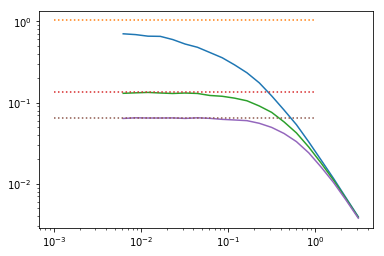

In [17]:
def PlotWinker(t, diameter, fmin=1e-3, fmax=1e0):
    L0 = 2 * t["L0"] / diameter
    for z in [0, 2, 5]:
        plt.loglog(1 / L0, t["Z" + str(z)], label="Z" + str(z))
        plt.loglog([fmin, fmax], [Noll[z], Noll[z]], ls="dotted")


PlotWinker(t, 100)